In [1]:
import torch 
import tiktoken
import torch.nn as nn 
inputs = "your journey starts with one step" 


In [2]:
## Tokenization
tokenizer = tiktoken.get_encoding("gpt2")
integers = tokenizer.encode(inputs)
print(integers)
print(len(integers))
input = torch.tensor(integers)
print(input.shape)
## Embedding 
torch.manual_seed(123)
embed_layer = nn.Embedding(20257, 3)

embedded_input = embed_layer(input)
print(embedded_input)


[14108, 7002, 4940, 351, 530, 2239]
6
torch.Size([6])
tensor([[ 0.5797,  0.4753,  0.1395],
        [ 1.0490,  0.3580, -0.6994],
        [ 2.5301,  0.3388, -0.2527],
        [ 0.3171, -0.8529, -1.4709],
        [-1.4560,  1.1582,  0.2196],
        [-1.4948,  0.2331, -1.2366]], grad_fn=<EmbeddingBackward0>)


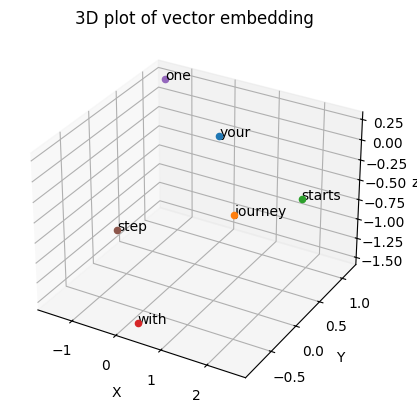

In [3]:
    
    #   [[ 0.5797,  0.4753,  0.1395],  your    (x1)
    #    [ 1.0490,  0.3580, -0.6994],  journey (x2)
    #    [ 2.5301,  0.3388, -0.2527],  starts  (x3)
    #    [ 0.3171, -0.8529, -1.4709],  with    (x4)
    #    [-1.4560,  1.1582,  0.2196],  one     (x5)
    #    [-1.4948,  0.2331, -1.2366]], step    (x6)
    
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

words = ["your", "journey", "starts", "with", "one", "step"]
x_cords = embedded_input[:,0].detach().numpy()
y_cords = embedded_input[:,1].detach().numpy()
z_cords = embedded_input[:,2].detach().numpy()

fig = plt.figure()

ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('z')

for x,y,z, word in zip(x_cords,y_cords,z_cords,words) : 
        ax.scatter(x,y,z)
        ax.text(x,y,z,word,fontsize=10)

plt.title( "3D plot of vector embedding")
plt.show()

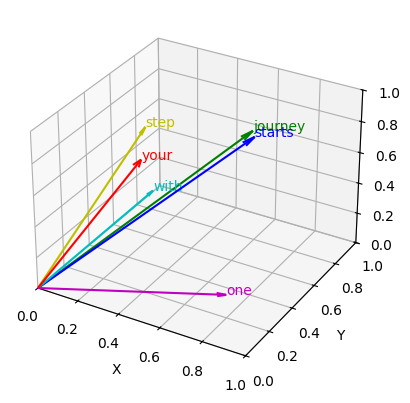

In [4]:
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)
fig = plt.figure()
ax = fig.add_subplot(111 , projection='3d')
x_cords = inputs[:,0].detach().numpy()
y_cords = inputs[:,1].detach().numpy()
z_cords = inputs[:,2].detach().numpy()
colors = ['r','g','b','c','m','y']
for x,y,z, word,color in zip(x_cords,y_cords,z_cords,words,colors) :
        ax.quiver(0,0,0,x,y,z,color=color,arrow_length_ratio=0.05)
        ax.text(x,y,z,word,fontsize=10,color=color)
        
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('z')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_zlim([0,1])

plt.show()

In [5]:
## computing the attention scores 
query = inputs[1] # second word : journey
attn_scores_2 = torch.empty(inputs.shape[0])

for i , x in enumerate(inputs) : 
    attn_scores_2[i] = torch.dot(query,x)
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [6]:
## computing the attention weights 
attn_weights_2 = attn_scores_2 / attn_scores_2.sum()
print(f"Attention weights : ",attn_weights_2)
print(f"sul of attention weights : ",attn_weights_2.sum())

Attention weights :  tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
sul of attention weights :  tensor(1.0000)


In [7]:
from torch.nn import functional as F

attn_weights_2 = F.softmax(attn_scores_2,dim=0)
print(attn_weights_2)
print(attn_weights_2.sum())

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
tensor(1.)


In [8]:
## computing the context for the second token 

context = torch.zeros(inputs.shape[1])

for i , x in  enumerate(inputs) :
     context += attn_weights_2[i] * x 
print(context)

tensor([0.4419, 0.6515, 0.5683])


In [9]:
## computing the attention weights for all the tokens in the sequence 

attn_scores = torch.empty(6,6)

for  i , x in enumerate(inputs) : 
    for j , y in enumerate(inputs) : 
        attn_scores[i,j] = torch.dot(x,y)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [10]:
# faster way with matrix multiplication 
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [11]:
attn_weights = F.softmax(attn_scores,dim=-1) ## normalize cross the columns >> the values at each row sum up to one 
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [12]:
all_context_vects = attn_weights @ inputs
print(all_context_vects)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


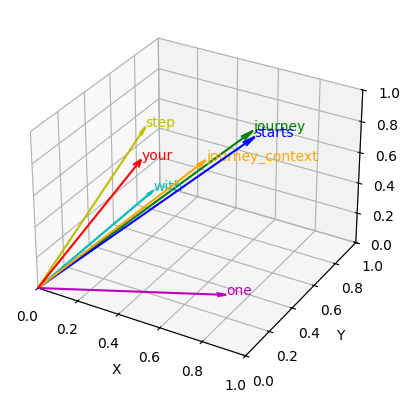

'\n        it is important to note that this non trainable weights we were working only capture the similarities between \n        the tokens of the sequence based on their embedding which may not represent the actual relations between in the contest \n        of the corresponding sequence , In order to capture that type of dependencies we need to work with trainable weights   \n'

In [13]:
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)
context_2 = [0.4419, 0.6515, 0.5683]

fig = plt.figure()
ax = fig.add_subplot(111 , projection='3d')
x_cords = inputs[:,0].detach().numpy()
y_cords = inputs[:,1].detach().numpy()
z_cords = inputs[:,2].detach().numpy()
colors = ['r','g','b','c','m','y']
for x,y,z, word,color in zip(x_cords,y_cords,z_cords,words,colors) :
        ax.quiver(0,0,0,x,y,z,color=color,arrow_length_ratio=0.05)
        ax.text(x,y,z,word,fontsize=10,color=color)
ax.quiver(0,0,0,context_2[0],context_2[1],context_2[2],color='orange',arrow_length_ratio=0.05)
ax.text(context_2[0],context_2[1],context_2[2],"journey_context",fontsize=10,color='orange')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('z')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_zlim([0,1])

plt.show()
## context vector has more information about the "journey" word (token)
## not only on its semantic meaning but also on each relation with the other word in the sequence 
"""
        it is important to note that this non trainable weights we were working only capture the similarities between 
        the tokens of the sequence based on their embedding which may not represent the actual relations between in the contest 
        of the corresponding sequence , In order to capture that type of dependencies we need to work with trainable weights   
"""

TRAINABLE WEIGHTS

In [14]:
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)

print(inputs.shape)

torch.Size([6, 3])


In [15]:
x_2 = inputs[1]
dim_in  = inputs.shape[1]
dim_out = 2  

In [16]:
torch.manual_seed(123)
w_q = nn.Parameter(torch.rand(dim_in,dim_out) , requires_grad=False)
w_k = nn.Parameter(torch.rand(dim_in,dim_out) , requires_grad=False)
w_v = nn.Parameter(torch.rand(dim_in,dim_out) , requires_grad=False)
### In GPT the dimensions are the same

In [17]:
print(w_k)

Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]])


In [18]:
query_2 = x_2 @ w_q 
key_2   = x_2 @ w_k
value_2 = x_2 @ w_v

In [19]:
queries = inputs @ w_q
keys = inputs @ w_k
values = inputs @ w_v
print(keys.shape)
print(values.shape)
print(queries.shape)
print(queries)
print(" ")
print(keys)

torch.Size([6, 2])
torch.Size([6, 2])
torch.Size([6, 2])
tensor([[0.2309, 1.0966],
        [0.4306, 1.4551],
        [0.4300, 1.4343],
        [0.2355, 0.7990],
        [0.2983, 0.6565],
        [0.2568, 1.0533]])
 
tensor([[0.3669, 0.7646],
        [0.4433, 1.1419],
        [0.4361, 1.1156],
        [0.2408, 0.6706],
        [0.1827, 0.3292],
        [0.3275, 0.9642]])


In [20]:
## weight W22

keys_2 = keys[1]
attn_score_22 = key_2.dot(query_2)
print(attn_score_22)

tensor(1.8524)


In [21]:
attn_scores = query_2 @ keys.T ## all attention scores for a given query
print(attn_scores)
print(attn_scores.shape)
print(queries @ keys.T)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])
torch.Size([6])
tensor([[0.9231, 1.3545, 1.3241, 0.7910, 0.4032, 1.1330],
        [1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440],
        [1.2544, 1.8284, 1.7877, 1.0654, 0.5508, 1.5238],
        [0.6973, 1.0167, 0.9941, 0.5925, 0.3061, 0.8475],
        [0.6114, 0.8819, 0.8626, 0.5121, 0.2707, 0.7307],
        [0.8995, 1.3165, 1.2871, 0.7682, 0.3937, 1.0996]])


In [22]:
attn_weights_2 = F.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
"""
      the normalization by the embedding dimension is done to improve the training performance by avoiding 
      small gradients.
      large dot products can result in very small gradients during backpropagation dur to the softmax function applied to them 
      which leads to gradients nearing zero ==> training slows down !!! 
      by scaling with square root of the embedding dimension this attention is called "scaled-dot product attention"
""" 
print(attn_weights_2)
print(attn_weights_2.sum())

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
tensor(1.)


In [23]:
context_2 = attn_weights_2 @ values
print(context_2)

tensor([0.3061, 0.8210])


In [24]:
class SelfAttention_V1(nn.Module) : 
    def __init__(self,d_in,d_out):
        super().__init__()
        self.w_q = nn.Parameter(torch.rand(d_in,d_out))
        self.w_k = nn.Parameter(torch.rand(d_in,d_out))
        self.w_v = nn.Parameter(torch.rand(d_in,d_out))
    def forward(self,x) : 
        keys    = x @ self.w_k 
        queries = x @ self.w_q 
        values  = x @ self.w_v 
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5,dim=-1)
        context_vec = attn_weights @ values
        return context_vec

In [25]:
torch.manual_seed(123)
self_attention = SelfAttention_V1(3,2)
print(f"Context od the tokens after self attention : \n\n", self_attention(inputs))

Context od the tokens after self attention : 

 tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [26]:
class SelfAttention_V2(nn.Module) : 
    def __init__(self,d_in,d_out,bias=False):
        super().__init__()
        self.w_q = nn.Linear(d_in,d_out,bias=bias)
        self.w_k = nn.Linear(d_in,d_out,bias=bias)
        self.w_v = nn.Linear(d_in,d_out,bias=bias)
    def forward(self,x) : 
        keys    = self.w_k(x) 
        queries = self.w_q(x) 
        values  = self.w_v(x) 
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5,dim=-1)
        context_vec = attn_weights @ values
        return context_vec

In [27]:
torch.manual_seed(789)
self_attention_2 = SelfAttention_V2(3,2)
print(f"Context od the tokens after self attention : \n\n", self_attention(inputs))

Context od the tokens after self attention : 

 tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


CAUSAL ATTENTION

In [28]:
queries = self_attention_2.w_q(inputs)
keys = self_attention_2.w_k(inputs)
print(queries.shape)
print(keys.shape)
attn_scores = queries @ keys.T
print(attn_scores.shape)
attn_weights = F.softmax(attn_scores / keys.shape[-1]**0.5,dim=-1)
print(attn_weights)

torch.Size([6, 2])
torch.Size([6, 2])
torch.Size([6, 6])
tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [29]:
context_length = attn_weights.shape[0]
mask_simple = torch.tril(torch.ones(context_length,context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [30]:
masked_simple = attn_weights * mask_simple ## ==> new attention scores that needs to be normalized 
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


In [31]:
row_sums = masked_simple.sum(dim=-1,keepdim=True)
masked_simple__norm = masked_simple / row_sums
print(f"masked attention weights : \n",masked_simple__norm)

masked attention weights : 
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


Masking the scores with -infinity 

In [32]:
mask = torch.triu(torch.ones(context_length,context_length),diagonal=1)
print(mask)
masked = attn_scores.masked_fill(mask.bool(),-torch.inf)
print("\nthe masked attention scores\n")
print(masked)

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

the masked attention scores

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [33]:
## no need for another norm , directly applying softmax
## No information leakage from future tokens :)
weights = torch.softmax(masked/keys.shape[-1]**0.5,dim=-1)
print(f"applying softmax and getting our weights : \n" , weights)

applying softmax and getting our weights : 
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [34]:
context = weights @ self_attention_2.w_v(inputs)
print(context)

tensor([[-0.0872,  0.0286],
        [-0.0991,  0.0501],
        [-0.0999,  0.0633],
        [-0.0983,  0.0489],
        [-0.0514,  0.1098],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


DROPOUT technique (for reducing overfitting)

In [35]:
torch.manual_seed(133)
dropout = nn.Dropout(0.5)
example = torch.ones(6,6)
print(dropout(example))

tensor([[0., 2., 2., 2., 2., 2.],
        [2., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 2.],
        [2., 0., 2., 2., 2., 2.],
        [2., 0., 0., 0., 0., 0.],
        [2., 2., 2., 0., 0., 2.]])


In [36]:
torch.manual_seed(133)
print(dropout(weights))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.1034, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.0000, 0.4925, 0.4638, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3869, 0.3327, 0.3331, 0.0000, 0.0000, 0.3058]],
       grad_fn=<MulBackward0>)


In [37]:
batch = torch.stack((inputs,inputs),dim=0)
print(batch.shape)
print(batch)

torch.Size([2, 6, 3])
tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])


In [38]:
class CausalAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,bias=True): 
        super().__init__()
        self.w_q = nn.Linear(d_in,d_out,bias=bias)
        self.w_k = nn.Linear(d_in,d_out,bias=bias)
        self.w_v = nn.Linear(d_in,d_out,bias=bias) 
        self.dropout = nn.Dropout(dropout)
        
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length,context_length),diagonal=1)
        )
        
    def forward(self,x):
        b , num_tokens , d_embed = x.shape
        queries = self.w_q(x)
        keys    = self.w_k(x)
        values  = self.w_v(x)
        
        attn_scores = queries @ keys.transpose(1,2) ## we need to transpose only the second and third dimensions
                                                    ## keeping the batch dim in place : (2,6,2) @ (2,2,6)
        attn_scores_masked = attn_scores.masked_fill_(self.mask.bool()[:num_tokens,:num_tokens], -torch.inf)    
        attn_weights = F.softmax(attn_scores_masked/keys.shape[-1]**0.5,dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context_vec = attn_weights @ values
        
        return context_vec
        

In [39]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in=3,d_out=2,context_length=context_length,dropout=0.2)
context = ca(batch)
print(f"context shape {context.shape}")
print(context)


context shape torch.Size([2, 6, 2])
tensor([[[ 0.0000,  0.0000],
         [ 0.0960,  0.6737],
         [ 0.0238,  0.7849],
         [ 0.1327,  1.2004],
         [ 0.0273,  0.9600],
         [ 0.1485,  1.1719]],

        [[-0.1200,  0.9924],
         [ 0.0356,  1.1733],
         [ 0.0821,  1.2313],
         [ 0.1631,  0.9488],
         [ 0.0823,  1.1635],
         [ 0.1140,  0.9304]]], grad_fn=<UnsafeViewBackward0>)


In [40]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(
                    d_in,d_out,context_length,dropout,bias
                ) 
             for _ in range(num_heads)]
        )
        
    def forward(self,x) : 
        return torch.cat([head(x) for head in self.heads] , dim=-1)

In [41]:
torch.manual_seed(123)
mulihead_attention = MultiHeadAttention(3,2,6,0.2,2)

combined_context = mulihead_attention(batch)

print(f"combined_context.shape  {combined_context.shape}")

print(f"\n",combined_context)

## in this implementation , the heads are processed sequentially , a better version would be processing 
## these heads in parallel

combined_context.shape  torch.Size([2, 6, 4])

 tensor([[[-0.5649,  0.2770,  0.5965,  0.1329],
         [-0.7343,  0.0072,  0.7363,  0.4071],
         [-0.7875, -0.0790,  0.4717,  0.2605],
         [-0.7093, -0.1053,  0.6847,  0.4487],
         [-0.6907, -0.1226,  0.5516,  0.4032],
         [-0.6624, -0.1351,  0.6346,  0.4367]],

        [[-0.5649,  0.2770,  0.5965,  0.1329],
         [-0.7343,  0.0072,  0.2624,  0.0585],
         [ 0.0000,  0.0000,  0.7752,  0.4825],
         [-0.7093, -0.1053,  0.6847,  0.4487],
         [-0.6907, -0.1226,  0.6651,  0.4285],
         [-0.4849, -0.0705,  0.3442,  0.2237]]], grad_fn=<CatBackward0>)


Modified Multi-Head attention class for parallel computing of attention heads 

In [42]:
class MultiHeadAttention_V2(nn.Module) : 
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,bias=False):
        super().__init__()
        assert(d_out % num_heads ==0 ) ,"d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        
        self.head_dim = d_out // num_heads
        
        self.w_q = nn.Linear(d_in,d_out,bias=bias)
        self.w_k = nn.Linear(d_in,d_out,bias=bias)
        self.w_v = nn.Linear(d_in,d_out,bias=bias)
        self.out_proj = nn.Linear(d_out,d_out)
        self.dropout  = nn.Dropout(dropout) 
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length,context_length),diagonal=1)
        )
    
    def forward(self,x):
        b,num_tokens,d_embed= x.shape
        
        queries = self.w_q(x) ## (b , num_tokens , d_out)
        print(f"queries :\n {queries}")
        keys    = self.w_k(x) ## (b , num_tokens , d_out)
        print(f"keys    : \n {keys}")
        values  = self.w_v(x) ## (b , num_tokens , d_out)
        print(f"values  : \n {values}")
        ## (b , num_tokens , d_out) -------->  (b , num_tokens , num_heads , head_dim)
        queries = queries.view(b,num_tokens,self.num_heads,self.head_dim)
        keys    = keys.view(b,num_tokens,self.num_heads,self.head_dim)
        values  = values.view(b,num_tokens,self.num_heads,self.head_dim)
        print(f"queries after view :\n {queries}")
        print(f"keys after view    :\n {keys}")
        print(f"values after view  :\n {values}")
        # (b , num_tokens , num_heads , head_dim) ------> (b , num_heads , num_tokens , head_dim)
        ## in this case each head should be able to access all the tokens but with different embeddings (keys values splitted over the different heads)
        keys    = keys.transpose(1,2) 
        queries = queries.transpose(1,2) 
        values  = values.transpose(1,2) 
        print(f"queries after transpose :\n {queries}")
        print(f"keys after transpose    :\n {keys}")
        print(f"values after transpose  :\n {values}")
        attn_scores = queries @ keys.transpose(-1,-2)
        print(f"Attention Scores : \n {attn_scores}")
        mask_bool = self.mask.bool()[:num_tokens,:num_tokens]
        attn_scores_masked = attn_scores.masked_fill_(mask_bool,-torch.inf)
        print(f"Attention Scores masked : \n {attn_scores_masked}")
        attn_weights = F.softmax(attn_scores_masked / keys.shape[-1]**0.5,dim=-1)
        print(f"Attention Weights : \n {attn_weights}")
        attn_weights = self.dropout(attn_weights)
        
        context = ( attn_weights @ values ).transpose(1,2)# (b , num_heads , num_tokens , head_dim) ------> (b , num_tokens , num_heads , head_dim) 
        
        context = context.contiguous().view(b,num_tokens,self.d_out)
        
        context = self.out_proj(context) # optional linear projection layer 
        
        return context
        

In [43]:
torch.manual_seed(123)
batch_size,context_length,d_in = batch.shape
d_out=6
mha = MultiHeadAttention_V2(d_in,d_out,context_length,0.2,num_heads=3)

context = mha(batch)

print(f"context.shape : ",context.shape)

print(f"Context after projection layer : ",context)

queries :
 tensor([[[-0.3536,  0.3965, -0.5740,  0.2727, -0.4519,  0.2216],
         [-0.3021, -0.0289, -0.8709,  0.1008, -0.7142, -0.1961],
         [-0.3015, -0.0232, -0.8628,  0.1060, -0.7127, -0.1971],
         [-0.1353, -0.0978, -0.4789,  0.0051, -0.3809, -0.1557],
         [-0.2052,  0.0870, -0.4744,  0.1696, -0.4861, -0.1597],
         [-0.1542, -0.1499, -0.5888, -0.0388, -0.4213, -0.1501]],

        [[-0.3536,  0.3965, -0.5740,  0.2727, -0.4519,  0.2216],
         [-0.3021, -0.0289, -0.8709,  0.1008, -0.7142, -0.1961],
         [-0.3015, -0.0232, -0.8628,  0.1060, -0.7127, -0.1971],
         [-0.1353, -0.0978, -0.4789,  0.0051, -0.3809, -0.1557],
         [-0.2052,  0.0870, -0.4744,  0.1696, -0.4861, -0.1597],
         [-0.1542, -0.1499, -0.5888, -0.0388, -0.4213, -0.1501]]],
       grad_fn=<UnsafeViewBackward0>)
keys    : 
 tensor([[[ 0.3326,  0.5659, -0.3132, -0.2272,  0.4772,  0.1063],
         [ 0.3558,  0.5643, -0.1536,  0.2768,  0.6770,  0.4980],
         [ 0.3412,  0.552